In [1]:
import dlib, cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.patheffects as path_effects

# load model
model_path = 'models/opencv_face_detector_uint8.pb'
config_path = 'models/opencv_face_detector.pbtxt'
net = cv2.dnn.readNetFromTensorflow(model_path, config_path)
conf_threshold = 0.7

sp = dlib.shape_predictor('models/shape_predictor_68_face_landmarks.dat')
facerec = dlib.face_recognition_model_v1('models/dlib_face_recognition_resnet_model_v1.dat')

In [2]:
def find_faces(img):
    h, w, _ = img.shape
    blob = cv2.dnn.blobFromImage(img, 1.0, (300, 300), [104, 117, 123], False, False)
    net.setInput(blob)
    
    dets=net.forward()
    
    rects, shapes = [], []
    shapes_np = np.zeros((dets.shape[2], 68, 2), dtype=np.int)
    for i in range(dets.shape[2]):
        confidence = dets[0, 0, i, 2]
        if confidence > conf_threshold:
            left= int(dets[0, 0, i, 3] * w)
            top= int(dets[0, 0, i, 4] * h)
            right= int(dets[0, 0, i, 5] * w)
            bottom= int(dets[0, 0, i, 6] * h)
            rect=((left,top),(right,bottom))
            rects.append(rect)
            d= dlib.rectangle(left,top,right,bottom)
            print(d)
            shape = sp(img,d)
        
        # convert dlib shape to numpy array
            for k in range(0, 68):
                shapes_np[i][k] = (shape.part(k).x, shape.part(k).y)

            shapes.append(shape)
    return rects, shapes, shapes_np

def encode_faces(img, shapes):
    face_descriptors = []
    for shape in shapes:
        face_descriptor = facerec.compute_face_descriptor(img, shape)
        face_descriptors.append(np.array(face_descriptor))

    return np.array(face_descriptors)


# Compute Saved Face Descriptions

In [3]:
img_paths = {
    'harry': 'img/harry.jpg',
    'ron': 'img/ron.jpg',
    'hermione': 'img/hermione.jpg',
}

descs = {
    'harry': None,
    'ron': None,
    'hermione': None,
}

for name, img_path in img_paths.items():
    img_bgr = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    _, img_shapes, _ = find_faces(img_rgb)
    descs[name] = encode_faces(img_rgb, img_shapes)[0]

np.save('img/descs.npy', descs)

[(261, 57) (375, 205)]
[(424, 192) (686, 523)]
[(505, 153) (691, 414)]


# Compute Input

In [4]:
img_bgr = cv2.imread('img/3.jpg')
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

rects, shapes, _ = find_faces(img_bgr)
descriptors = encode_faces(img_bgr, shapes)

[(82, 71) (125, 127)]
[(205, 66) (262, 136)]
[(396, 78) (436, 146)]


# Visualize Output

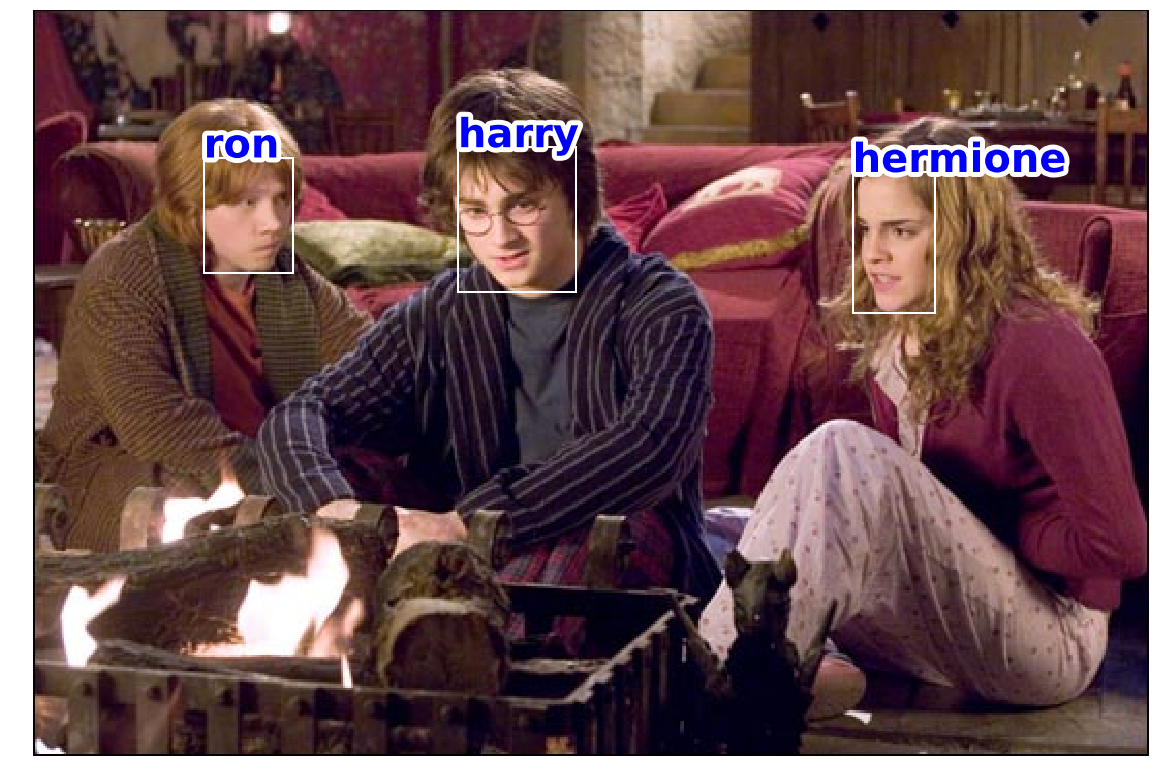

In [5]:
fig, ax = plt.subplots(1, figsize=(20, 20))
ax.imshow(img_rgb)

for i, desc in enumerate(descriptors):
    
    found = False
    for name, saved_desc in descs.items():
        dist = np.linalg.norm([desc] - saved_desc, axis=1)

        if dist < 0.6:
            found = True

            text = ax.text(rects[i][0][0], rects[i][0][1], name,
                    color='b', fontsize=40, fontweight='bold')
            text.set_path_effects([path_effects.Stroke(linewidth=10, foreground='white'), path_effects.Normal()])
            rect = patches.Rectangle(rects[i][0],
                                 rects[i][1][0] - rects[i][0][0],
                                 rects[i][1][1] - rects[i][0][1],
                                 linewidth=2, edgecolor='w', facecolor='none')
            ax.add_patch(rect)

            break
    
    if not found:
        ax.text(rects[i][0][0], rects[i][0][1], 'unknown',
                color='r', fontsize=20, fontweight='bold')
        rect = patches.Rectangle(rects[i][0],
                             rects[i][1][0] - rects[i][0][0],
                             rects[i][1][1] - rects[i][0][1],
                             linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

plt.axis('off')
plt.savefig('img/output.png')
plt.show()